# **Detection of Diabetic Retinopathy**

Diabetic retinopathy (DR) causes vision loss due to retinal blood vessel damage, with limited screening access in remote areas. This project proposes a deep learning model using CNNs to detect and classify DR stages from retinal images, enabling fast, accurate, and accessible diagnosis through telemedicine, reducing the risk of blindness.

Saving diabetic-1.png to diabetic-1.png


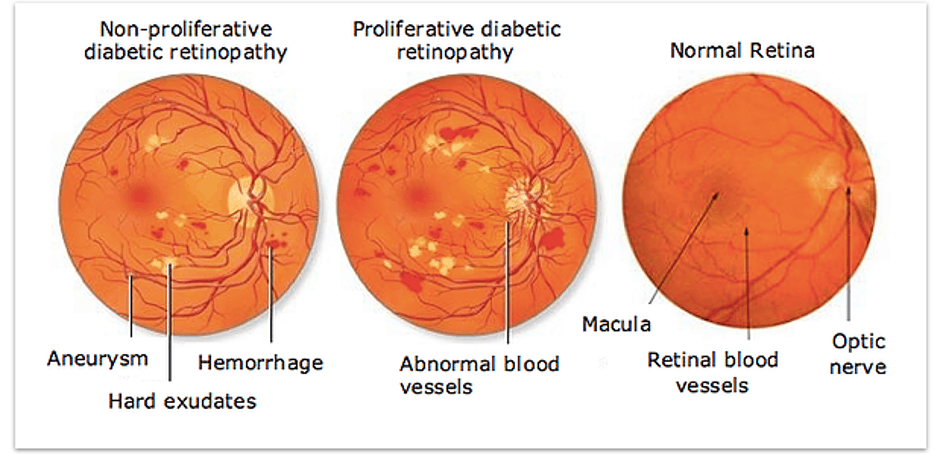

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded=files.upload()
Image('diabetic-1.png',width=1000)

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetic-retinopathy-resized:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F131128%2F418031%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T173613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ad258c3a1e95c760dc4ccf97a3f4dbc45eb35a080bfd98179ece6b8e4212ef63e5311afb75a213e05a1fb733b964e180604cc95305f8014adde5271bf127267cde934eaddef53db9b56fffff2ae077d052d6079a8e27336dcf2ba9c089339a7c5e114048423d4126fe72d3a33e467de8120bf6fa38ce9e623bf064864fe9d8fdd788d985af2f443cb3a33a04306273db4a113fbdb6cd340810b7790ed4d83f1673f28e4407dd5989d8c48af3cb48cf9c907837ffa063b452fd95884c7320fcee94a7b5d2a06320b4d63e1b5415296abd739be3d1c57f10373055d9431a77d0c50d0604ceed26d334f2f3a299d743845b0c62ca7fde830c9aec8c0ddaf7769c8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7785957896 bytes downloaded
Downloaded and uncompressed: diabetic-retinopathy-resized
Data source import complete.


In [ ]:
#importing libraries
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
df = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['image', 'level']
train = df[:28000]
test  = df[28000:]

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['level'].value_counts())
print('-' * 15)
print(test['level'].value_counts())

(28000, 2) (7126, 2)
---------------
level
0    20528
2     4256
1     1955
3      706
4      555
Name: count, dtype: int64
---------------
level
0    5282
2    1036
1     488
3     167
4     153
Name: count, dtype: int64


Text(0.5, 0, 'Diagnosis')

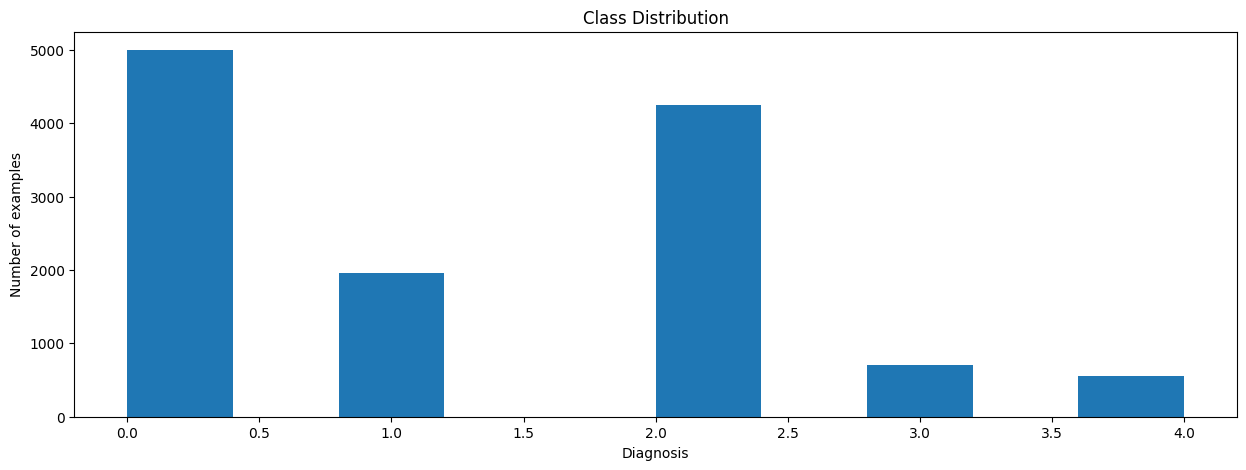

In [ ]:
# CLASS DISTRIBUTION
# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['level'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

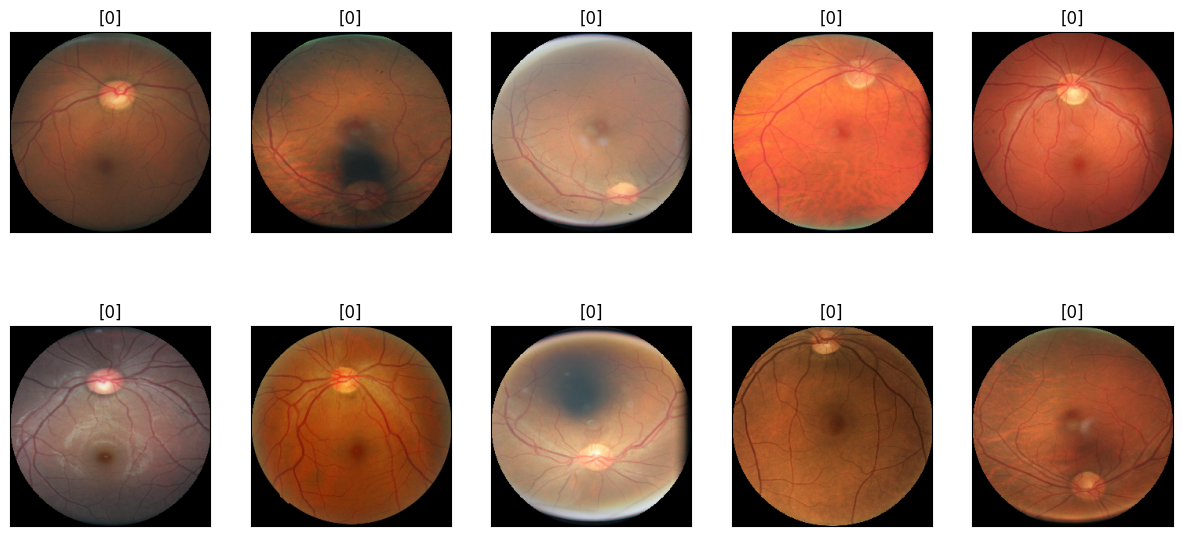

In [ ]:
# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])
sample = Data(data       = train.iloc[0:10],
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = sample_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample,
                                            batch_size  = 10,
                                            shuffle     = False,
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)

    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [ ]:
#TRANSFORMATIONS

# parameters
batch_size = 16
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

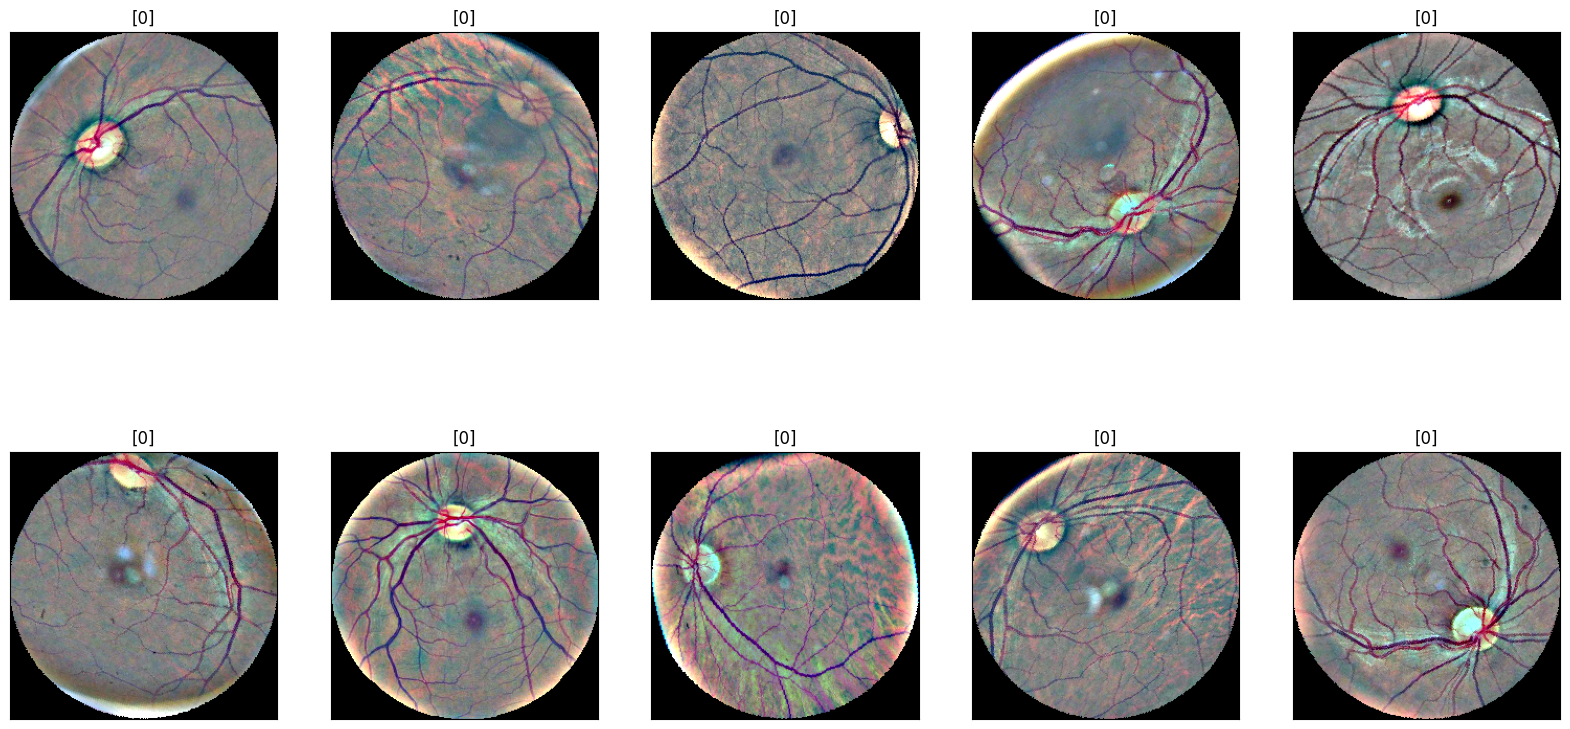

In [ ]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data       = train.iloc[0:10],
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = train_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample,
                                            batch_size  = batch_size,
                                            shuffle     = True,
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)

    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [ ]:
image_size = 256
#IMAGE PREPROCESSING

def prepare_image(path,
                  sigmaX         = 10,
                  do_random_crop = False):

    '''
    Preprocess image
    '''

    # import imagepre
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))

    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [ ]:
#CROP FUNCTIONS

def crop_black(img,
               tol = 7):

    '''
    Perform automatic crop of black areas
    '''

    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]

        if (check_shape == 0):
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img

In [ ]:
def circle_crop(img,
                sigmaX = 10):

    '''
    Perform circular crop around image center
    '''

    height, width, depth = img.shape

    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)

    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img

In [ ]:
def random_crop(img,
                size = (0.9, 1)):

    '''
    Random crop
    '''

    height, width, depth = img.shape

    cut = 1 - random.uniform(size[0], size[1])

    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]

    return img

In [ ]:
class EyeData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [ ]:
class Data(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_black(image, tol = 7)
        image = cv2.resize(image, (int(image_size), int(image_size)))
        image = circle_crop(image, sigmaX = 10)
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

# Assume the code for loading and preprocessing the data is already executed
# Assuming 'train' DataFrame is already defined

# Output the counts of different levels of diabetic retinopathy in the training dataset
print(train['level'].value_counts())
print('-' * 15)

# Define the resampling strategy targeting only class 0
under_sampling = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)

# Resample the training data
X_resampled, y_resampled = under_sampling.fit_resample(train.drop(columns=['level']), train['level'])

# Combine resampled features and target into a DataFrame
train_resampled = pd.concat([pd.DataFrame(X_resampled, columns=train.drop(columns=['level']).columns),
                             pd.DataFrame(y_resampled, columns=['level'])], axis=1)

# Reset indices
train_resampled.reset_index(drop=True, inplace=True)
# train_resampled = shuffle(train_resampled, random_state=42)

# Check the class distribution after resampling
print(train_resampled['level'].value_counts())
train = train_resampled


level
0    20528
2     4256
1     1955
3      706
4      555
Name: count, dtype: int64
---------------
level
0    5000
2    4256
1    1955
3     706
4     555
Name: count, dtype: int64


In [ ]:
# IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):

    # import image
    img = cv2.imread('../input/diabetic-retinopathy-resized/resized_train/resized_train/{}.jpeg'.format(observation['image']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height

    # save
    image_stats.append(np.array((observation['level'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['level', 'height', 'width', 'channels', 'ratio']

  0%|          | 0/12472 [00:00<?, ?it/s]

Text(0.5, 0, 'Ratio')

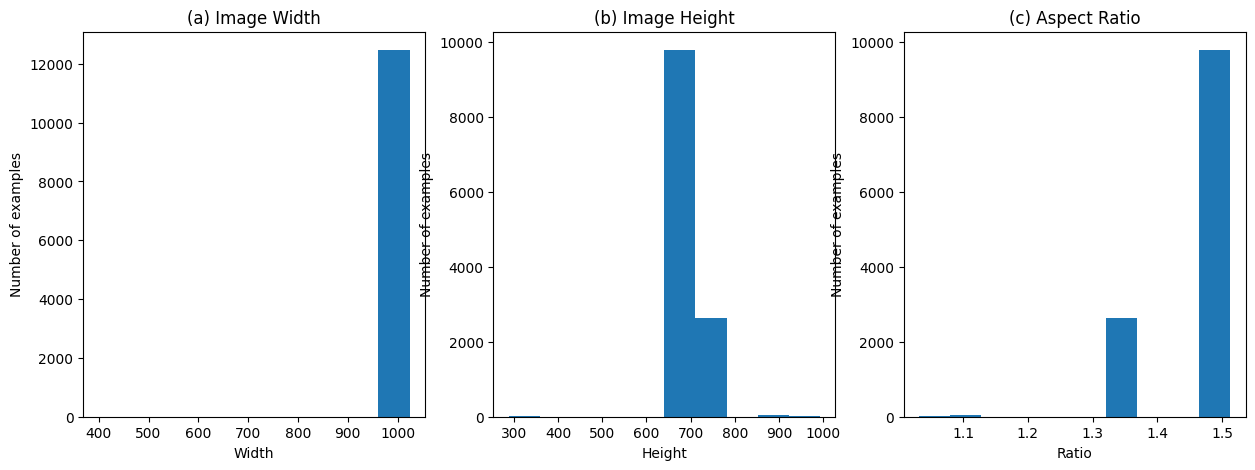

In [ ]:
# IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

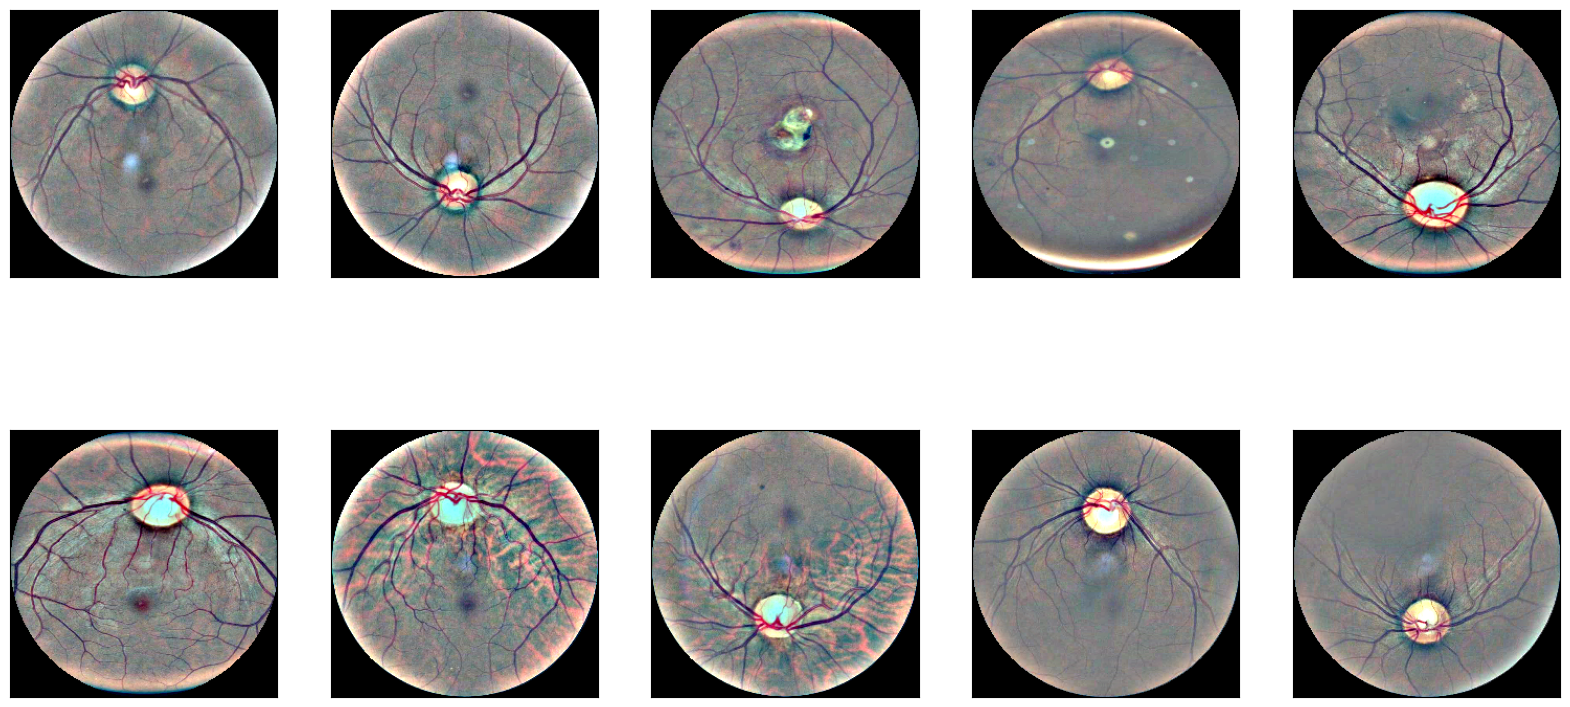

In [ ]:
#EXAMINE FIRST BATCH (TEST)
test = test.reset_index()
# get dataset
sample = EyeData(data       = test.iloc[0:10],
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = test_trans,
                      itype ='.jpeg',
                      do_random_crop = False)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample,
                                            batch_size  = batch_size,
                                            shuffle     = False,
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']

    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break

In [ ]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of the input to the fully connected layers based on the image size and convolutional layers
        self.fc_input_size = self._get_fc_input_size(256, 5)  # Assuming 256x256 images and 5 maxpooling layers
        self.classifier = nn.Sequential(
            # Fully connected layers
            nn.Linear(512 * self.fc_input_size * self.fc_input_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _get_fc_input_size(self, input_size, num_maxpool_layers):
        """Calculate the size of the input to the fully connected layers"""
        for _ in range(num_maxpool_layers):
            input_size = (input_size + 1) // 2
        return input_size

num_classes = 5 # Provide the actual number of classes
model = CustomModel(num_classes)

print(model)


CustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [ ]:
#VALIDATION SETTINGS

# placeholders
oof_preds = np.zeros((len(test), 5))

# timer
cv_start = time.time()

In [ ]:
#PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 2###################################################
early_stop = 35

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

In [ ]:
#DATA PREPARATION

# load splits
data_train = train
data_valid = test

# create datasets
train_dataset = EyeData(data      = data_train,
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans,
                             itype ='.jpeg')
valid_dataset = EyeData(data       = data_valid,
                            directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                            transform  = valid_trans,
                            itype ='.jpeg')

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = True,
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = False,
                                           num_workers = 4)

In [ ]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [ ]:
#MODELING EPOCHS

# placeholders
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

model_name = 'DR'

# initialize and send to GPU
# model = init_pre_model()
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# training and validation loop
for epoch in range(max_epochs):
    ### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    #TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)


    #INFERENCE

    # switch regime
    model.eval()

    # loop through batches
    for batch_i, data in enumerate(valid_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)

    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    #EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['level'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    #EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        torch.save(model.state_dict(), 'models/model_{}.bin'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break


# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

- epoch 1/2 | lr = 0.001 | trn_loss = 1.3467 | val_loss = 1.0230 | val_kappa = 0.0000 | 11.42 min
- epoch 2/2 | lr = 0.001 | trn_loss = 1.3323 | val_loss = 1.0713 | val_kappa = 0.0000 | 11.53 min
Did not met early stopping. Best results: loss = 1.0230, kappa = 0.0000 (epoch 1)


Finished in 23.40 minutes


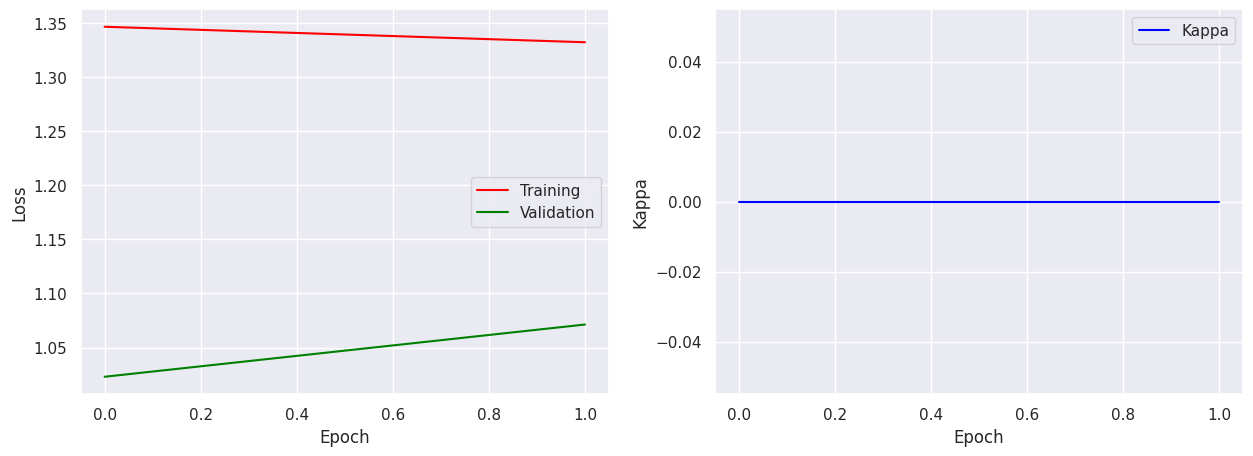

In [ ]:
#PLOT LOSS AND KAPPA DYNAMICS
sns.set()
# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

In [ ]:
#RECHECK PERFORMANCE

# rounding
oof_preds_round = oof_preds.argmax(axis = 1)
coef = [0.5, 1.5, 2.5, 3.5]
for i, pred in enumerate(oof_preds_round):
    if pred < coef[0]:
        oof_preds_round[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds_round[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds_round[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds_round[i] = 3
    else:
        oof_preds_round[i] = 4

# compute kappa
oof_loss  = criterion(torch.tensor(oof_preds), torch.tensor(test['level']).view(-1).type(torch.long))
oof_kappa = metrics.cohen_kappa_score(test['level'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF loss  = {:.4f}'.format(oof_loss))
print('OOF kappa = {:.4f}'.format(oof_kappa))

OOF loss  = 1.0713
OOF kappa = 0.0000


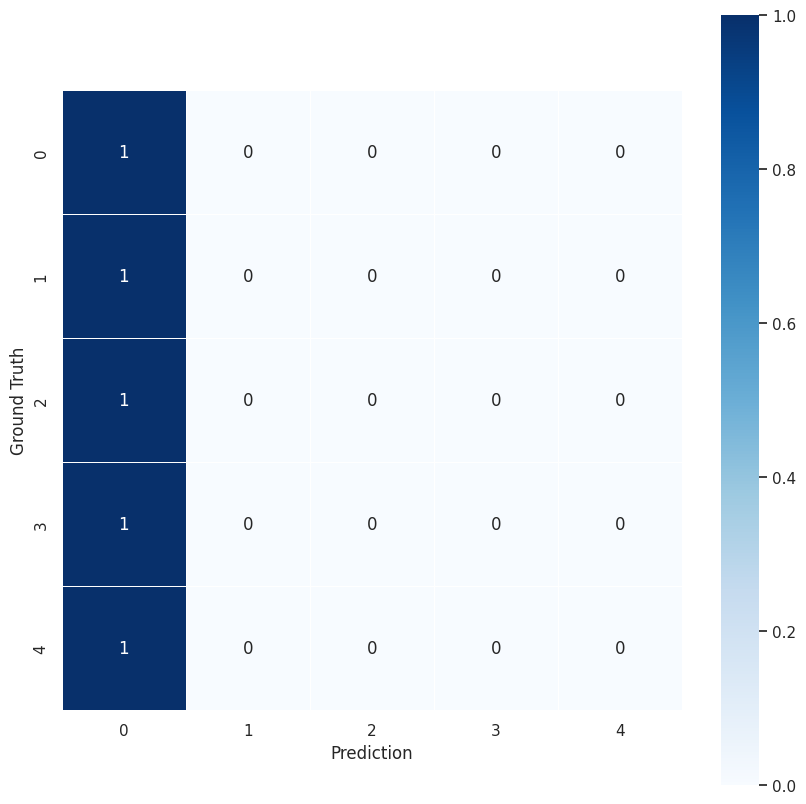

In [ ]:
#CONFUSION MATRIX

# construct confusion matrix
cm = confusion_matrix(test['level'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

In [ ]:
from sklearn.metrics import classification_report

#Classification Report Test
print('\n Classification Report in Test: \n',classification_report(test['level'], oof_preds_round))


 Classification Report in Test: 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      5282
           1       0.00      0.00      0.00       488
           2       0.00      0.00      0.00      1036
           3       0.00      0.00      0.00       167
           4       0.00      0.00      0.00       153

    accuracy                           0.74      7126
   macro avg       0.15      0.20      0.17      7126
weighted avg       0.55      0.74      0.63      7126

